In [ ]:
# House keeping settings
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False


In [ ]:
import os
import pandas as pd
import json
from typing import List, Dict

from model_engine.assets.utils import load_asset
from model_engine.io.loaders import load_json
# from model_engine.power.post_sale import PowerModelBuilder
# from model_engine.analysis.suggesters import evaluate_datesplits
# from model_engine.io.s3_schema_manager import S3SchemaManager
# from model_engine.io.utils import download_artifacts_from_s3
import warnings

from zaml.common.utils import load_state

import model_engine, zaml
# from projectz import ZInfo
model_engine.__version__, zaml.__version__


/home/lyt/.conda/envs/penfed_modeling/lib/python3.10/site-packages/zamlexplain/utils_compile.py:23: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC
/home/lyt/.conda/envs/penfed_modeling/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/lyt/.conda/envs/penfed_modeling/lib/python3.1

('v1.13.0', '34.5.2')

In [ ]:
with open('project_info.json', "r") as f:
    project_info = json.load(f)
client_name = project_info['client_name']
bureau_production = project_info['bureau_production']
national_model_type = project_info['national_model_category'] # options are 'standard_model', 'mega_model', 'standard_model_member_data', 'standard_model_ln_data', 'standard_model_ln_member_data'- None defaults to 'standard_model'
product_version: int = int(project_info['product_version']) # previously product_version
model_iteration_products: List[str] = project_info["model_iteration_products"]

print(client_name, bureau_production, national_model_type, model_iteration_products, product_version)


origencepocv2 experian standard_model_member_data ['autoloan'] 1


# 1. Final Ensemble Model

In [ ]:
input_model_id = 'model1Ensemble'
final_model_path = f'/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/{input_model_id}'

client_model_name = 'clientmodel2b'
national_model_name = 'nationalmodel2b'
ensemble_weights = [0.5, 0.5]


In [ ]:
client_model_path = f'/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/{client_model_name}'
national_model_path = f'/d/shared/users/lyt/penfed_poc1_national_models/{national_model_name}'


In [ ]:
from zaml.model.modeling import LinearEnsembleModel

client_submodel = load_state(os.path.join(client_model_path, 'model.obj'))
national_submodel = load_state(os.path.join(national_model_path, 'model.obj'))
baseline_model_pipeline = load_state(os.path.join(client_model_path, 'pipeline.obj'))

sub_models = [('XGBoostModel_0', client_submodel), 
             ('XGBoostModel_1', national_submodel)]

model = LinearEnsembleModel(sub_models, weights=ensemble_weights)
baseline_model_pipeline.model = model


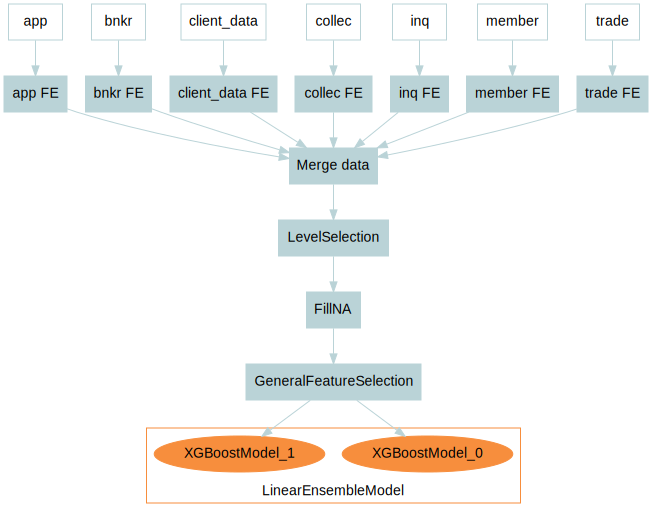

In [ ]:
baseline_model_pipeline.display()


In [ ]:
model.save_state(os.path.join(final_model_path, "model.obj"))
baseline_model_pipeline.save_state(os.path.join(final_model_path, "pipeline.obj"))


'/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/model1Ensemble/pipeline.obj'

In [ ]:
# Modify model artifacts of the client model to be in PSA2.0 

psa20_client_model_path = '/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/clientmodel2bpsa20'

split = ['test', 'train']
data_files = ['app', 'fe_data', 'scores', 'zest_scores', 'target']

for s in split: 
    for d in data_files: 
        df= pd.read_parquet(os.path.join(client_model_path, f'{s}_{d}.parquet'))
        new_dir = os.path.join(psa20_client_model_path, f'{d}/split={s}/data=client')
        print(new_dir)
        os.makedirs(new_dir, exist_ok=True)

        new_filename = "data_0.parquet"
        new_path = os.path.join(new_dir, new_filename)
        df.to_parquet(new_path)
        
# Update artifact_manifest.json


In [ ]:
# # Modify model artifacts of the national model to be in PSA1.0

# psa10_national_path = '/d/shared/users/lyt/penfed_poc1_national_models/nationalmodel2bpsa10'

# split = ['test', 'train']
# data_files = ['app', 'fe_data', 'scores', 'zest_scores', 'target']

# for s in split: 
#     for d in data_files: 
#         if 'scores' in d: 
#             df= pd.read_parquet(os.path.join(psa10_national_path, f'overall_{d}/split={s}/data=national/data_0.parquet'))
#         else: 
#             df= pd.read_parquet(os.path.join(psa10_national_path, f'{d}/split={s}/data=national/data_0.parquet'))
            
#         print(f'{s}_{d}')
#         new_path = os.path.join(psa10_national_path, f'{s}_{d}.parquet')
#         df.to_parquet(new_path)


In [ ]:
with open('/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/clientmodel2b/asset.json', 'r') as file:
    asset = json.load(file)


model_path = '/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/clientmodel2b'

desc = make_data_description(asset, model_path, model_alias='client_model')

import pyarrow.parquet as pq

def make_model_data_summary( data_split, model_path):
    result = {}
    for split, period in data_split.items():
        result[split] = {'num_of_rows': None}     
        if isinstance(model_path, list):
            app_path = [os.path.join(each, f'{split}_app.parquet') for each in model_path]
            num_rows = sum(pq.ParquetFile(path).num_row_groups * pq.ParquetFile(path).metadata.num_rows for path in app_path)
        else:
            app_path = os.path.join(model_path, f'{split}_app.parquet')
            num_rows = pq.ParquetFile(app_path).num_row_groups * pq.ParquetFile(app_path).metadata.num_rows
        result[split]['num_of_rows'] = {f'{split}_app': num_rows}
    return result


def make_data_description(asset, model_path, model_alias='client_model'):
    desc = {}
    desc['data_split'] = asset['config']['data_split'] # get original data split from asset
    desc['target'] = asset['data']['target']['asset']['info']['col'] # get target col from asset
    desc['data_sources'] = list(asset['data'].keys())
    desc['data_summary'] = make_model_data_summary(asset['config']['data_split'], model_path)
    desc['alias'] = model_alias
    return desc


In [28]:

psa20_client_model_path = '/d/shared/silver_projects_v2/origencepocv2/autoloanv1/modeling/model_artifacts/autoloan/clientmodel2bpsa20'


In [ ]:
config = {
    "ensemble_weights": [0.5, 0.5],
    "clients": [
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2cooperativeteachers_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2hawaiiusa_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2financialpartners_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wecu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oefcu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2orangecounty_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2vantagewestcu_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2centralwillamette_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2servicecu_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2traviscu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oklahomacentralcu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2telhio_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2usccu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2abileneteachers_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wsecu_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2indianamembers_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2industrialcu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2silverstateschools_autoindirect"
    ],
    "baseline_model": psa20_client_model_path,
    "submodels": [
        national_model_path
    ],
    "client_data_split": {
        "test": {
        "start_date": "2022-07-28",
        "end_date": "2023-03-31"
        }
    },
    "target": "final_DQ60_m24",
    "bureau": "equifax",
    "model_splits": [
        "train"
    ],
    "model_alias": {
        "baseline_model": "client_model",
        "submodels": [
            "national_model"
        ]
    },
    "data_alias": {
        "baseline_model": {
            "train": "client",
            "valid": "client",
            "test": "client"
        },
        "submodels": [
            {
                "train": "national",
                "valid": "national",
                "test": "client"
            }
        ]
    }
}


In [ ]:
from model_engine.client_predictor.client_predictor import ClientPredictor

cp = ClientPredictor(conf = config,
                    outpath = final_model_path)
output = cp.run()










                      but the loaded object is built on ZAML None. Loading serialized
                      object from different versions are not recommended and may yield unexpected
                      errors or results.

                      but the loaded object is built on ZAML None. Loading serialized
                      object from different versions are not recommended and may yield unexpected
                      errors or results.



Sampling down to 1000000
Sampling down to 1000000


INFO:zaml.artifact_engine.logger:Executing InputArtifact <baseline_model_asset>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <client_predictor_config>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <baseline_model_supporting_asset>...
INFO:zaml.artifact_engine.logger:Not all required inputs are available for optional artifact <baseline_model_supporting_asset>, thus it will be omitted.
INFO:zaml.artifact_engine.logger:Executing InputArtifact <submodel_0>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <input_data>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <data_split>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <test_sample_weight>...
INFO:zaml.artifact_engine.logger:Not all required inputs are available for optional artifact <test_sample_weight>, thus it will be omitted.
INFO:zaml.artifact_engine.logger:Executing InputArtifact <baseline_model_model>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <bas

{'ensemble_weights': [0.5, 0.5], 'clients': ['/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2cooperativeteachers_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2hawaiiusa_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2financialpartners_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wecu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oefcu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2orangecounty_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2vantagewestcu_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2centralwillamette_autoloan', '/d/shared/silver_projects_v2/p


INFO:zaml.artifact_engine.logger:Finished <data_description>, total time spent: 0:00:03.411758
INFO:zaml.artifact_engine.logger:Executing UnfoldDataDescription <unfold_data_description>...



{'ensemble_weights': [0.5, 0.5], 'clients': ['/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2cooperativeteachers_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2hawaiiusa_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2financialpartners_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wecu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oefcu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2orangecounty_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2vantagewestcu_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2centralwillamette_autoloan', '/d/shared/silver_projects_v2/p

INFO:zaml.artifact_engine.logger:Finished <unfold_data_description>, total time spent: 0:00:02.086731
INFO:zaml.artifact_engine.logger:Executing Versions <versions>...
INFO:zaml.artifact_engine.logger:Finished <versions>, total time spent: 0:00:00.000427
INFO:zaml.artifact_engine.logger:Executing ClientSplitterArtifact <splitter>...
INFO:zaml.artifact_engine.logger:Finished <splitter>, total time spent: 0:00:00.000596
INFO:zaml.artifact_engine.logger:Executing NewModel <model>...
INFO:zaml.artifact_engine.logger:Finished <model>, total time spent: 0:00:00.000446
INFO:zaml.artifact_engine.logger:Executing CombineDataArtifact <train_app>...
INFO:zaml.artifact_engine.logger:Finished <train_app>, total time spent: 0:00:00.552656
INFO:zaml.artifact_engine.logger:Executing CombineDataArtifact <train_fe_data>...
INFO:zaml.artifact_engine.logger:Finished <train_fe_data>, total time spent: 0:00:00.967313
INFO:zaml.artifact_engine.logger:Executing CombineDataArtifact <train_target>...
INFO:zaml.

-------------------------
Name: app
Transformer type: None
Number of features: 18
Time spent: 0.000s
-------------------------
Name: bnkr
Transformer type: None
Number of features: 8
Time spent: 0.000s
-------------------------
Name: client_data
Transformer type: None
Number of features: 431
Time spent: 0.000s
-------------------------
Name: collec
Transformer type: None
Number of features: 5
Time spent: 0.000s
-------------------------
Name: inq
Transformer type: None
Number of features: 13
Time spent: 0.000s
-------------------------
Name: member
Transformer type: None
Number of features: 28
Time spent: 0.000s
-------------------------
Name: trade
Transformer type: None
Number of features: 216
Time spent: 0.000s
-------------------------
Name: app FE
Transformer type: OneToOneEngine
Number of features: 0
Time spent: 0.039s
-------------------------
Name: bnkr FE
Transformer type: ManyToOneEngine
Number of features: 8
Time spent: 0.026s
-------------------------
Name: client_data FE
T


INFO:zaml.artifact_engine.logger:Finished <test_fe_data>, total time spent: 0:00:30.694361


-------------------------
Name: FillNA
Transformer type: FillNA
Number of features: 271
Time spent: 3.840s
-------------------------
Name: GeneralFeatureSelection
Transformer type: GeneralFeatureSelection
Number of features: 271
Time spent: 0.001s


INFO:zaml.artifact_engine.logger:Executing FinalDataArtifact <final_test_target>...
INFO:zaml.artifact_engine.logger:Finished <final_test_target>, total time spent: 0:00:00.000477
INFO:zaml.artifact_engine.logger:Executing SubmodelScoresArtifact <test_submodel_scores>...
INFO:zaml.artifact_engine.logger:Finished <test_submodel_scores>, total time spent: 0:00:05.287425
INFO:zaml.artifact_engine.logger:Executing TestFeatureImportanceArtifact <feature_importance>...


INFO:zaml.artifact_engine.logger:Finished <feature_importance>, total time spent: 0:01:09.083934
INFO:zaml.artifact_engine.logger:Executing TestSubmodelFeatureImportanceArtifact <submodel_feature_importance>...












































































INFO:zaml.artifact_engine.logger:Finished <submodel_feature_importance>, total time spent: 0:00:33.261931
INFO:zaml.artifact_engine.logger:Executing ScoresArtifact <test_scores>...
INFO:zaml.artifact_engine.logger:Finished <test_scores>, total

In [ ]:
# asset = cp.build_asset()


In [ ]:
# state = cp.load_state(asset)










                      but the loaded object is built on ZAML None. Loading serialized
                      object from different versions are not recommended and may yield unexpected
                      errors or results.

                      but the loaded object is built on ZAML None. Loading serialized
                      object from different versions are not recommended and may yield unexpected
                      errors or results.



Sampling down to 1000000
Sampling down to 1000000


In [ ]:
# state['cache'].keys()


dict_keys(['baseline_model_train_app', 'baseline_model_train_target', 'baseline_model_train_fe_data', 'baseline_model_asset', 'baseline_model_model', 'baseline_model_pipeline', 'baseline_model_splitter', 'submodel_0_artifacts', 'client_predictor_config', 'feature_definition_list', 'key_factor_mapping_list', 'submodel_0'])

In [ ]:
# state['cache']['submodel_0_artifacts'].keys()


dict_keys(['train_app', 'train_target', 'train_fe_data', 'asset', 'model', 'pipeline', 'splitter', 'supporting_asset'])

In [ ]:
# state['cache']['submodel_0'].keys()


dict_keys(['train_app', 'train_target', 'train_fe_data', 'asset', 'model', 'pipeline', 'splitter', 'supporting_asset'])

In [ ]:
# graph = cp.create_graph(state)


In [ ]:
# output = cp.excute_graph(graph, state)


INFO:zaml.artifact_engine.logger:Executing InputArtifact <baseline_model_asset>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <client_predictor_config>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <baseline_model_supporting_asset>...
INFO:zaml.artifact_engine.logger:Not all required inputs are available for optional artifact <baseline_model_supporting_asset>, thus it will be omitted.
INFO:zaml.artifact_engine.logger:Executing InputArtifact <submodel_0>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <input_data>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <data_split>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <test_sample_weight>...
INFO:zaml.artifact_engine.logger:Not all required inputs are available for optional artifact <test_sample_weight>, thus it will be omitted.
INFO:zaml.artifact_engine.logger:Executing InputArtifact <baseline_model_model>...
INFO:zaml.artifact_engine.logger:Executing InputArtifact <bas

{'ensemble_weights': [0.5, 0.5], 'clients': ['/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2cooperativeteachers_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2hawaiiusa_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2financialpartners_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wecu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oefcu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2orangecounty_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2vantagewestcu_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2centralwillamette_autoloan', '/d/shared/silver_projects_v2/p

INFO:zaml.artifact_engine.logger:Finished <data_description>, total time spent: 0:00:03.792790
INFO:zaml.artifact_engine.logger:Executing UnfoldDataDescription <unfold_data_description>...



{'ensemble_weights': [0.5, 0.5], 'clients': ['/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2cooperativeteachers_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2hawaiiusa_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2financialpartners_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wecu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oefcu_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2orangecounty_autoloan', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2vantagewestcu_autoloanv2', '/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2centralwillamette_autoloan', '/d/shared/silver_projects_v2/p

INFO:zaml.artifact_engine.logger:Finished <unfold_data_description>, total time spent: 0:00:01.805363
INFO:zaml.artifact_engine.logger:Executing Versions <versions>...
INFO:zaml.artifact_engine.logger:Finished <versions>, total time spent: 0:00:08.925462
INFO:zaml.artifact_engine.logger:Executing ClientSplitterArtifact <splitter>...
INFO:zaml.artifact_engine.logger:Finished <splitter>, total time spent: 0:00:00.000797
INFO:zaml.artifact_engine.logger:Executing NewModel <model>...
INFO:zaml.artifact_engine.logger:Finished <model>, total time spent: 0:00:00.000554
INFO:zaml.artifact_engine.logger:Executing CombineDataArtifact <train_app>...
INFO:zaml.artifact_engine.logger:Finished <train_app>, total time spent: 0:00:00.482363
INFO:zaml.artifact_engine.logger:Executing CombineDataArtifact <train_fe_data>...
INFO:zaml.artifact_engine.logger:Finished <train_fe_data>, total time spent: 0:00:00.655012
INFO:zaml.artifact_engine.logger:Executing CombineDataArtifact <train_target>...
INFO:zaml.

-------------------------
Name: app
Transformer type: None
Number of features: 18
Time spent: 0.000s
-------------------------
Name: bnkr
Transformer type: None
Number of features: 8
Time spent: 0.000s
-------------------------
Name: client_data
Transformer type: None
Number of features: 431
Time spent: 0.000s
-------------------------
Name: collec
Transformer type: None
Number of features: 5
Time spent: 0.000s
-------------------------
Name: inq
Transformer type: None
Number of features: 13
Time spent: 0.000s
-------------------------
Name: member
Transformer type: None
Number of features: 28
Time spent: 0.000s
-------------------------
Name: trade
Transformer type: None
Number of features: 216
Time spent: 0.000s
-------------------------
Name: app FE
Transformer type: OneToOneEngine
Number of features: 0
Time spent: 0.039s
-------------------------
Name: bnkr FE
Transformer type: ManyToOneEngine
Number of features: 8
Time spent: 0.025s
-------------------------
Name: client_data FE
T


INFO:zaml.artifact_engine.logger:Finished <test_fe_data>, total time spent: 0:00:31.493529


-------------------------
Name: FillNA
Transformer type: FillNA
Number of features: 271
Time spent: 3.749s
-------------------------
Name: GeneralFeatureSelection
Transformer type: GeneralFeatureSelection
Number of features: 271
Time spent: 0.001s


INFO:zaml.artifact_engine.logger:Executing FinalDataArtifact <final_test_target>...
INFO:zaml.artifact_engine.logger:Finished <final_test_target>, total time spent: 0:00:00.000509
INFO:zaml.artifact_engine.logger:Executing SubmodelScoresArtifact <test_submodel_scores>...
INFO:zaml.artifact_engine.logger:Finished <test_submodel_scores>, total time spent: 0:00:04.015614
INFO:zaml.artifact_engine.logger:Executing TestFeatureImportanceArtifact <feature_importance>...


INFO:zaml.artifact_engine.logger:Finished <feature_importance>, total time spent: 0:01:10.505152
INFO:zaml.artifact_engine.logger:Executing TestSubmodelFeatureImportanceArtifact <submodel_feature_importance>...












































































INFO:zaml.artifact_engine.logger:Finished <submodel_feature_importance>, total time spent: 0:00:36.001600
INFO:zaml.artifact_engine.logger:Executing ScoresArtifact <test_scores>...
INFO:zaml.artifact_engine.logger:Finished <test_scores>, total

# 2. Concatenate Analysis and Target Data

In [ ]:
clients = [
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2cooperativeteachers_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2hawaiiusa_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2financialpartners_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wecu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oefcu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2orangecounty_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2vantagewestcu_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2centralwillamette_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2servicecu_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2traviscu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2oklahomacentralcu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2telhio_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2usccu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2abileneteachers_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2wsecu_autoloanv2",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2indianamembers_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2industrialcu_autoloan",
    "/d/shared/silver_projects_v2/project_power/shared_data/processed/client_data/OrigencePOCv2silverstateschools_autoindirect"
    ]


In [ ]:
target_all = pd.DataFrame()
analysis_all = pd.DataFrame()

for i in clients: 
    target = pd.read_parquet(os.path.join(i, 'target.parquet'))
    ana = pd.read_parquet(os.path.join(i, 'client_data.parquet'))
    
    for suffix in ["_autoloanv2", "_autoloan", "_autoindirect"]:
        if i.endswith(suffix):
            name = i[77:-len(suffix)]
            print(name)
            
    target['client'] = name
    ana['client'] = name
    
    target_all = pd.concat([target_all, target])
    analysis_all = pd.concat([analysis_all, ana])


OrigencePOCv2cooperativeteachers
OrigencePOCv2hawaiiusa
OrigencePOCv2financialpartners
OrigencePOCv2wecu
OrigencePOCv2oefcu
OrigencePOCv2orangecounty
OrigencePOCv2vantagewestcu
OrigencePOCv2centralwillamette
OrigencePOCv2servicecu
OrigencePOCv2traviscu
OrigencePOCv2oklahomacentralcu
OrigencePOCv2telhio
OrigencePOCv2usccu
OrigencePOCv2abileneteachers
OrigencePOCv2wsecu
OrigencePOCv2indianamembers
OrigencePOCv2industrialcu
OrigencePOCv2silverstateschools


In [ ]:
# Clients in the model test split 

analysis_all[ (analysis_all.appDate >= '2022-07-28') & (analysis_all.appDate <= '2023-03-31')].client.value_counts()


client
OrigencePOCv2wsecu                  77992
OrigencePOCv2traviscu               72633
OrigencePOCv2servicecu              67266
OrigencePOCv2vantagewestcu          44944
OrigencePOCv2wecu                   40800
OrigencePOCv2industrialcu           19535
OrigencePOCv2orangecounty           17855
OrigencePOCv2telhio                 17279
OrigencePOCv2indianamembers         17227
OrigencePOCv2silverstateschools     16532
OrigencePOCv2centralwillamette      15137
OrigencePOCv2financialpartners      14296
OrigencePOCv2oefcu                  10342
OrigencePOCv2oklahomacentralcu       6511
OrigencePOCv2abileneteachers         5922
OrigencePOCv2usccu                   5767
OrigencePOCv2hawaiiusa               5128
OrigencePOCv2cooperativeteachers      721
Name: count, dtype: int64

In [ ]:
!ls /d/shared/silver_projects_v2/origencepocv2/autoloanv1/shared_data/placeholder


In [ ]:
!ls /d/shared/silver_projects_v2/OrigencePOCv2abileneteachers/autoloanv1/shared_data/equifax/processed/target


dq_dates.parquet  final_target.parquet	target_config_autoloan.json
final_target.csv  target_analysis


In [ ]:
extra_cols = ['CustomScore',
 'MonthlyLiability',
 'CustomScore5',
 'FraudScore',
 'MembershipMonths',
 'ChildSupport',
 'CustomScore2',
 'BankruptcyScore',
 'Alimony',
 'MonthlyRent',
 'MonthlyIncomeOther1',
 'MonthlyIncomeBaseSalary',
 'OccupancyDuration',
 'MonthlyIncomeOther2',
 'CustomScore4',
 'MemberType',
 'MonthlyIncomeOther',
 'EntryDate',
 'BranchName',
 'MemberNumber',
 'SymitarSuffix',
 'ProductCode',
 'loanRequestType',
 'Rate',
 'LoanStatus',
 'ApprovalCode',
 'FundedStatus',
 'FundingDate',
 'OccupancyStatus',
 'AllButThisDebtToIncomeFund',
 'AllButThisDebtToIncomeUW',
 'ThisDebtToIncomeUW',
 'ThisDebtToIncomeUW.1',
 'TotalDebtToIncomeFund',
 'MonthlyIncomeOtherDescription1',
 'MonthlyIncomeOtherDescription2',
 'Tier',
 'EntryDate.1',
 'FundedStatus.1',
 'FundingDate.1',
 'LoanNumber.1',
 'FundedStatus.2',
 'LoanType.1',
 'CreditScore.1',
 'CustomScore.1',
 'CustomScore3',
 'MonthlyIncomeBaseSalary.1',
 'MonthlyIncomeOther.1',
 'MonthlyIncomeOther1.1',
 'MonthlyIncomeOther2.1',
 'OccupancyStatus.1',
 'City.1',
 'JointCreditScore.1',
 'JointCustomScore3',
 'JointMembershipMonths.1',
 'JointOccupancyStatus',
 'IndMailingCountry',
 'IndOccupation',
 'AllButThisDebtToIncomeFund.1',
 'AllButThisDebtToIncomeUW.1',
 'AmountToLiveOn',
 'AvailableRevolveAmtOverTotalRevCredit',
 'EstimatedMonthlyPayment',
 'FundedLTV',
 'NewSecuredAggregateAmountExcludingML',
 'NewSecuredAggregateAmountExcludingMLJoint',
 'NewUnsecuredAggregateAmount',
 'NewUnsecuredAggregateAmountJoint',
 'NumberOfOpenRevolvingAccounts',
 'RevolvingDebtAmounts',
 'ThisDebtToIncomeFund',
 'ThisDebtToIncomeUW.2',
 'TotalAssetValue',
 'ThisDebtToIncomeFund.1',
 'ThisDebtToIncomeUW.3',
 'TotalAssetValue.1',
 'ThisDebtToIncomeFund.2',
 'ThisDebtToIncomeUW.4',
 'TotalExistingLoanAmount',
 'TotalMonthlyDebt',
 'TotalSecureBalanceExcludeMtg',
 'TotalSecureBalanceExcludeMtgOverAnnualIncome',
 'TotalUnsecureBalance',
 'TotalUnsecureBalanceOverTotalDebt',
 'AmountApproved.1',
 'AmountOwedToLender',
 'AmountRequested.1',
 'aprApproved',
 'LoanTerm',
 'PurposeType.1',
 'LOS',
 'appDate_time',
 'flgDirect',
 'benchmark_scores_from_client',
 'Unnamed:0',
 'Unnamed:23',
 'Unnamed:24',
 'Unnamed:26',
 'LTV',
 'LTV-ApprovedAmt/VehicleValue',
 'RequestedLoanTerm',
 'zest_score',
 'oldflgApproved',
 'oldflgFunded',
 'oldflgAutoApproved',
 'Loan.Type',
 'Loan.Product',
 'App.Is.Member',
 'CoApp.Is.Member',
 'Is.CU.Employee',
 'Is.CoApp.CU.Employee',
 'Applicant.Seller.Employee',
 'CoApp.Seller.Employee',
 'Application.Stage',
 'Application.Status',
 'Current.Decision.User.Name',
 'Initial.Decision.Status',
 'Application.Number',
 'EFX_VS40',
 'ARCHIVE_Q',
 'oldflgAutoDenied',
 'LoanAmt',
 'priunsecureddebtratiomonthly',
 'sumltvapprovedamountvehiclevalue',
 'prirevolvingratio',
 'priunsecuredbalanceratioannual',
 'Score',
 'ScoreModel',
 'mileage',
 'ageofoldesttrademonths',
 'pri_discretionaryincomebfrnewln',
 'sumunsecureddebtratiomonthly',
 'modelyear',
 'OwnershipCode',
 'sumtotalgrossmonthlyincome',
 'currentdelinquenttradecount',
 'satisfactorytradecount',
 'Addperiodofemployment',
 'AppZestAIScore',
 'Application.Submitted.By',
 'Current.Branch',
 'SyntheticFraudScore',
 'AutoApproved_backup',
 'AutoDeclined_backup',
 'flgAddressPOBox',
 'flgAddressMilitary',
 'Emp.Name',
 'Combined.Unsecured.Debt.Ratio.Annual',
 'Combined.LenderHost.Total.Unsec.Credit',
 'Combined.Disc.Inc.With.New.Loan.Current',
 'Vehicle.Mileage',
 'Vehicle.Year',
 'Assigner.User.Name',
 'vantage40',
 'income_insight',
 'Decision.User.Code2',
 'Decision.User.Code',
 'Count',
 'Combined.DTI.With.New.Loan.Less.Trade.In.Initial',
 'Combined.DTI.With.New.Loan.Less.TradeIn.Current',
 'Combined.PTI.Initial',
 'Combined.PTI.Current',
 'Combined.Disc.Inc.Before.New.Loan.Current',
 'FlgApproved.1',
 'FlgFunded.1',
 'FlgAutoApproved.1',
 'FlgAutoDenied.1',
 'ApplicationStage',
 'DownPaymentAmount',
 'Channel',
 'LoanProduct',
 'InitialDecisionStatus',
 'LoanOfficer',
 'ApplicationNumber',
 'AdverseActionReasons',
 'LenderLoanProductName',
 'OccupancyLength',
 'CollateralIsNew',
 'Year',
 'make',
 'Model',
 'DecisionIsCurrent',
 'IsIndirect',
 'LoanType_ori',
 'EmploymentFlag',
 'flgAge18',
 'SelfEmployedMonths',
 'AnnualIncome',
 'flgAge21',
 'appYear',
 'VehicleAge',
 'DOB_year',
 'Age',
 'flg>_22_<_44',
 'flgAge>_35_<_54',
 'flgAge>55',
 'flgZIP_85339',
 'InitialsumLTVApprovedAmountVehicleValue',
 'InitialsumPTIPaymentToIncome',
 'PeriodOfEmploymentflgSelfEmployed',
 'InitialsumDTINewLoan',
 'CreditScore',
 'ClientZestScore',
 'benchmark_scores_name',
 'flgBorrowerOld',
 'USER_REF_NO',
 'Current.Decision.Date',
 'Funded.Gross.Amt',
 'Funded.Rate',
 'App.Disc.Inc.With.New.Loan.Current',
 'App.Total.Monthly.Pmts.With.New.Loan.Less.Trade.In.Current',
 'App.Unsecured.Debt.Ratio.Annual',
 'App.CB2.Score',
 'ApprovalDate',
 'ApprovedLTV.1',
 'CounterOfferDate',
 'OverrideCode',
 'follow_consumer_id',
 'EmployerType',
 'Term',
 'flgAutoDenied',
 'loanamount',
 'periodofemployment',
 'periodofresidence',
 'Application.Submitted.Date',
 'Initial.Decision.Date.Time',
 'Initial.Decision.Tier',
 'vs40',
 'OtherExpense2',
 'OtherExpense1',
 'AmountAdvanced',
 'AmountChargeOff',
 'BackEndLTV',
 'EstimatedVehiclePayment',
 'ExactLastMonthlyPayment',
 'FrontEndLTV',
 'FundingAPR',
 'FundingLoanTerm',
 'FundingRate',
 'IndProductCode',
 'IsIndirectLoan',
 'MonthlyPayment',
 'PersonalLoanType',
 'PurposeDescription',
 'TotalDebtToIncomeUW',
 'TotalFinancedPayment',
 'TotalUnsecureBalanceOverAnnualIncome',
 'TotalVehicleValue',
 'TradeAllowance',
 'VehicleMake',
 'VehicleModel',
 'VehicleSalesPrice',
 'VehicleType',
 'VehicleValue',
 'isNewVehicle',
 'Initial.Decision.Approved.Amt',
 'Initial.Decision.Rate',
 'Initial.Decision.Term',
 'Originated.User.Name',
 'App.Emp.Time',
 'CoApp.Emp.Time',
 'LTV.Funded.Requested.Amt.Less.Fees.And.Paper.Add.Ons.Vehicle.Value',
 'LTV.Initial.Requested.Amt.Less.Fees.And.Paper.Add.Ons.Vehicle.Value',
 'Vehicle.Condition',
 'MonthlyDisposableIncome',
 'sumLTVRequestedAmountVehicleValue',
 'FULL_DATE_application',
 'APPLICATION_SOURCE',
 'APPLICANT_TYPE',
 'ACCOUNT_NUMBER',
 'LOAN_ID',
 'GENERATION',
 'DECISION_ENGINE_application',
 'RISK_GRADE_application',
 'IS_SUPER_PRIME',
 'SCORE_TIER',
 'fileName_application',
 'FULL_DATE_applicant',
 'APP_NUMBER',
 'APP_SOURCE',
 'APP_CATEGORY',
 'IS_DENIED',
 'IS_CANCELLED_OR_WITHDRAWN',
 'IS_APPROVED',
 'IS_FUNDED',
 'DECISION_ENGINE_applicant',
 'DECISION_TYPE',
 'RISK_GRADE_applicant',
 'FUNDED_DATE',
 'VEHICLE_YEAR',
 'VEHICLE_MAKE',
 'VEHICLE_MODEL',
 'VEHICLE_MILEAGE',
 'VEHICLE_AGE',
 'PURCHASE_PRICE',
 'EMPLOYMENT_INCOME_x',
 'TOTAL_ADDITIONAL_COSTS',
 'TOTAL_FINANCED',
 'TOTAL_PAY_NEW_LOAN',
 'TOTAL_PAY_NEW_LOAN_LESS_TRADE',
 'COMBINED_DISC_INCOME_BEFORE_NEW_LOAN',
 'COMBINED_EST_PAY_AMOUNT',
 'DISP_INCOME_AFTER_NEW_LOAN',
 'OTD_LTV_PCT',
 'FRONT_END_LTV_PCT',
 'DTI_BEFORE_NEW_LOAN_PCT',
 'DTI_AFTER_NEW_LOAN_PCT',
 'PAY_TO_INCOME_NEW_LOAN_PCT',
 'UBAI_PCT',
 'fileName_applicant',
 'EMPLOYMENT_INCOME_y',
 'auto_approval',
 'auto_decline',
 'fileName',
 'Y_m',
 'LTV_FE',
 'LTV_OTD',
 'Collateral_Make',
 'TradeInAmt',
 'flgBorrower_old',
 'ApplicationId',
 'Unnamed:_0',
 'IndPrevOccupancyDuration',
 'CardType',
 'CreditLimit',
 'RequestedCardName',
 'RequestedCreditLimit',
 'AmountApproved',
 'ExactMonthlyPayment',
 'LTV-AmtRequested/VehicleValue',
 'zest_score_from_cient',
 'Unnamed:52',
 'Unnamed:53',
 'Current.Decision.AuthorizedOfficer']


In [ ]:
analysis_all[extra_cols] = analysis_all[extra_cols].astype(str)


In [105]:
analysis_all.to_parquet('/d/shared/silver_projects_v2/origencepocv2/autoloanv1/shared_data/placeholder/processed/supporting_artifacts/analysis_data.parquet')


In [ ]:
target_all.to_parquet('/d/shared/silver_projects_v2/origencepocv2/autoloanv1/shared_data/placeholder/processed/target/final_target.parquet')


In [ ]:
target_all.to_csv('/d/shared/silver_projects_v2/origencepocv2/autoloanv1/shared_data/placeholder/processed/target/final_target.csv',
                index=True)


In [ ]:
analysis_all.head(1)


,prob_<62,prob_62+,prob_female,prob_male,bisgAian,bisgApi,bisgBlack,bisgHispanic,bisgMulti,bisgWhite,...,CreditLimit,RequestedCardName,RequestedCreditLimit,AmountApproved,ExactMonthlyPayment,LTV-AmtRequested/VehicleValue,zest_score_from_cient,Unnamed:52,Unnamed:53,Current.Decision.AuthorizedOfficer
ZEST_KEY,,,,,,,,,,,,,,,,,,,,,
61972419_1_122_02,1.0,0.0,0.99593,0.00407,0.009709,0.002477,0.57975,0.020855,0.011597,0.375612,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [104]:
analysis_all.to_csv('/d/shared/silver_projects_v2/origencepocv2/autoloanv1/shared_data/placeholder/processed/supporting_artifacts/analysis_data.csv',
                   index=True)


In [ ]:
analysis_all.shape


(2220699, 432)

In [ ]:
target_all.head(1)


,appId,appDate,flgFunded,flgApproved,final_DQ30_m3,final_DQ30_m3_source,final_DQ30_m3_status,final_DQ30_m3_sample_weight,final_DateDQ30_m3,final_DQ30_m6,...,final_CO_m36_status,final_CO_m36_sample_weight,final_DateCO_m36,proxy_MSO_target_CO,proxy_CO,final_MSO_target_CO,final_CO,ARCHIVE_DATE,client,follow_consumer_id
ZEST_KEY,,,,,,,,,,,,,,,,,,,,,
61972419_1_122_02,61972419,2020-01-06,1,1,NaN,missing,nohit,1,NaT,NaN,...,nohit,1,NaT,NaN,NaN,NaN,NaN,2019-12-31,OrigencePOCv2silverstateschools_aut,NaN


# 3. Create Model in ProjectZ

In [ ]:
# derived metadata variables
from projectz.objects.internal_classes import ProductMapper
product_mapper = ProductMapper()
# concat model iteration products to single string
model_iteration_product_concat: str = product_mapper.convert_product_list(model_iteration_products) # concat string. See ProjectZV2 guide
# in some places version 1 doesn't have suffix; only >= v2
version_suffix = f"v{product_version}" if product_version > 1 else ""
print(model_iteration_product_concat)


autoloan


In [ ]:
from projectz import ZInfo
z_info = ZInfo() # Initialize z_info
try:
    z_info.connect_client(name = client_name) # connect to client level
except ValueError as e:
    print(f"Client doesn't exist. Please double check the input or rerun notebook 0 to create new client\nError message: {e}")


INFO:projectz.logger:Connected client: origencepocv2
INFO:projectz.logger:Connected client: origencepocv2
INFO:projectz.logger:Connected to client: origencepocv2


In [ ]:
dataset_model_type = ['underwriting']
dataset_data_source = ['placeholder']
dataset_product = ['autoloan']
dataset_version = 1


In [ ]:
# Create dataset if not exist
try:
    z_info.connect_dataset(
        model_type=dataset_model_type,
        data_source=dataset_data_source,
        product=dataset_product,
        version=dataset_version
    )
    print(f'Successfully connect to existing dataset with ({dataset_model_type}, [{dataset_data_source}], {dataset_version})')
except ValueError:
    z_info.create_dataset(
        model_type=dataset_model_type,
        data_source=dataset_data_source,
        product=dataset_product,
        version=dataset_version
    )
    print(f'Successfully create a new dataset with ({dataset_model_type}, [{dataset_data_source}], {dataset_version})')
finally:
    print(f'Create projectz for dataset version = {dataset_version}')


INFO:projectz.logger:Connected dataset: autoloanv1
INFO:projectz.logger:Not all dirs exist for dataset.
INFO:projectz.logger:Connected dataset: autoloanv1
INFO:projectz.logger:Connected to dataset: autoloanv1


Successfully connect to existing dataset with (['underwriting'], [['equifax']], 1)
Create projectz for dataset version = 1


In [ ]:
z_info = ZInfo()
z_info.connect_client(name="origencepocv2")
z_info.connect_dataset(model_type=["underwriting"], data_source=["placeholder"],
                       product=[ "autoloan"], version=1)
z_info.connect_model_iteration(model_type=["underwriting"], data_source=["placeholder"],
                               product=["autoloan"], name="model1Ensemble")
z_info.connect_model_delivery(model_type="underwriting", product="autoloan", version=1, legacy_allproducts_delivery=False)


INFO:projectz.logger:Connected client: origencepocv2
INFO:projectz.logger:Connected client: origencepocv2
INFO:projectz.logger:Connected to client: origencepocv2
INFO:projectz.logger:Connected dataset: autoloanv1
INFO:projectz.logger:Connected dataset: autoloanv1
INFO:projectz.logger:Connected to dataset: autoloanv1
INFO:projectz.logger:Connected model_iteration: autoloan/model1Ensemble
INFO:projectz.logger:Connected model_iteration: autoloan/model1Ensemble
INFO:projectz.logger:Connected to model_iteration: autoloan/model1Ensemble
INFO:projectz.logger:Connected model_delivery: autoloanv1
INFO:projectz.logger:Connected model_delivery: autoloanv1
INFO:projectz.logger:Connected to model_delivery: autoloanv1
INFO:projectz.logger:Connected model_iteration: autoloan/model1Ensemble


In [ ]:
from z_artifact_etl.pipeline_name_manager import PipelineNameManager
z_info_config =  PipelineNameManager(z_info).dump_z_info_to_dict()
archive_data(data=z_info_config, path="./z_info_config.json")


ModuleNotFoundError: No module named 'z_artifact_etl'

In [ ]:
z_info_config = load_data('z_info_config.json')
pipeline_manager = PipelineNameManager()
z_info = pipeline_manager.load_z_info_from_dict(z_info_config)


In [ ]:
z_info.create_dataset(
    model_type=dataset_model_type,
    data_source=dataset_data_source,
    product=dataset_product,
    version=dataset_version
)


INFO:projectz.logger:Created dirs for dataset autoloanv1.


In [ ]:
dataset_model_type = ['underwriting']
dataset_data_source = ['equifax']
dataset_product = ['autoloan']
dataset_version = 1


In [ ]:
# Connect to the dataset
try:
    z_info.connect_dataset(
        model_type=dataset_model_type,
        data_source=dataset_data_source,
        product=dataset_product,
        version=dataset_version
    )
except ValueError:
    print("Dataset not found with the given configuration. Please double check the settings or manually fix in the cell above.")


INFO:projectz.logger:Connected dataset: autoloanv1
INFO:projectz.logger:Not all dirs exist for dataset.
INFO:projectz.logger:Connected dataset: autoloanv1
INFO:projectz.logger:Connected to dataset: autoloanv1


In [ ]:
z_info_config = load_data('z_info_config.json')
pipeline_manager = PipelineNameManager()
z_info = pipeline_manager.load_z_info_from_dict(z_info_config)


In [ ]:
input_model_id 


'model1Ensemble'

In [ ]:
model_iteration_name: str = "model1Ensemble"


In [ ]:
model_iteration_model_type: List[str] = dataset_model_type # usually same as dataset
model_iteration_data_source: List[str] = dataset_data_source # usually same as dataset
model_iteration_products: List[str] = model_iteration_products # Defined before. Usually a subset of dataset
print(f"""
PLEASE CHECK Model Iteration configuration:
- model_type: {model_iteration_model_type}
- Data Source: {model_iteration_data_source}
- Product: {model_iteration_products}
- Name: {model_iteration_name}
""")



PLEASE CHECK Model Iteration configuration:
- model_type: ['underwriting']
- Data Source: ['placeholder']
- Product: ['autoloan']
- Name: model1Ensemble



In [ ]:
# create model iteration
# NOTE: this step is irreversible
# Comment this section if you connect and rewrite to an existing model iteration
z_info.create_model_iteration(
    model_type=model_iteration_model_type,
    data_source=model_iteration_data_source,
    product=model_iteration_products,
    name=model_iteration_name
)


INFO:projectz.logger:Not all dirs exist for model_iteration.
INFO:projectz.logger:Created dirs for model_iteration autoloan/model1Ensemble.
INFO:projectz.logger:Created model_iteration autoloan/model1Ensemble in ProjectZ.
INFO:projectz.logger:Connected model_iteration: autoloan/model1Ensemble


In [ ]:
try:
    z_info.connect_model_iteration(
        model_type=model_iteration_model_type,
        data_source=model_iteration_data_source,
        product=model_iteration_products,
        name=model_iteration_name
    )
except ValueError:
    print("Dataset not found with the given configuration. Please check the settings above and rerun this cell if they were incorrect.")
    print("If this configuration is new, refer to projectz v2 user guide to create and connect new model iteration")


INFO:projectz.logger:Connected model_iteration: autoloan/model1Ensemble
INFO:projectz.logger:Connected model_iteration: autoloan/model1Ensemble
INFO:projectz.logger:Connected to model_iteration: autoloan/model1Ensemble


In [ ]:
model_iteration_products


['autoloan']

In [ ]:
z_info.create_model_delivery(
    model_type=model_iteration_model_type[0], # Should be underwriting
    product=model_iteration_products[0],
    version=1, # double check version
    legacy_allproducts_delivery=False # set to False for new model delivery- this param was only used for migrating old allproducts projects to ProjectZ V2
)


INFO:projectz.logger:Not all dirs exist for model_delivery.
INFO:projectz.logger:Created dirs for model_delivery autoloanv1.
INFO:projectz.logger:Created model_delivery autoloanv1 in ProjectZ.
INFO:projectz.logger:Connected model_delivery: autoloanv1


In [27]:
z_info.connect_model_delivery(
    model_type=model_iteration_model_type[0], # Should be underwriting
    product=model_iteration_products[0],
    version=1, # double check version
    legacy_allproducts_delivery=False # set to False for new model delivery- this param was only used for migrating old allproducts projects to ProjectZ V2
)



INFO:projectz.logger:Connected model_delivery: autoloanv1
INFO:projectz.logger:Connected model_delivery: autoloanv1
INFO:projectz.logger:Connected to model_delivery: autoloanv1


In [ ]:
# set the current connected model iteration to final
z_info.model_iteration.set_final()


INFO:projectz.logger:Connected model_iteration: autoloan/model1Ensemble
